In [1]:
import pandas as pd
import numpy as np
import io
import requests
import datetime
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
from array import array

# Loading in data set

In [2]:
url="https://raw.githubusercontent.com/ymlai87416/PythonPlayground/master/Python%20notebook/lab8.csv"
s=requests.get(url).content
returns_df=pd.read_csv(io.StringIO(s.decode('utf-8')), index_col=0, infer_datetime_format=True)

# The CER model

In [3]:
# Estimate the parameters: multivariate
mu_hat_annual = np.mean(returns_df)*12
sigma2_annual = np.var(returns_df)*12   
sigma_annual = np.sqrt(sigma2_annual)
cov_mat_annual = returns_df.cov()*12
cov_hat_annual = returns_df.cov().iloc[0,1]*12    
rho_hat_annual = returns_df.corr().iloc[0,1]

# The annual estimates of the CER model parameters for Boeing and Microsoft
mu_boeing = mu_hat_annual["rboeing"]
mu_msft = mu_hat_annual["rmsft"]
sigma2_boeing =  sigma2_annual["rboeing"]
sigma2_msft = sigma2_annual["rmsft"]
sigma_boeing = sigma_annual["rboeing"]
sigma_msft = sigma_annual["rmsft"]
sigma_boeing_msft = cov_hat_annual
rho_boeing_msft =rho_hat_annual 

# A portfolio of Boeing and Microsoft stock

In [4]:
# The ratio Boeing stock vs Microsoft stock (adds up to 1)
boeing_weights = np.arange(-1, 2.1, 0.1)
msft_weights = 1-boeing_weights

# Portfolio parameters
mu_portfolio = boeing_weights * mu_boeing + msft_weights * mu_msft
sigma2_portfolio =  np.power(boeing_weights,2) * sigma2_boeing + np.power(msft_weights, 2) * sigma2_msft + 2*boeing_weights*msft_weights*rho_boeing_msft*sigma_boeing*sigma_msft
sigma_portfolio = np.sqrt(sigma2_portfolio)


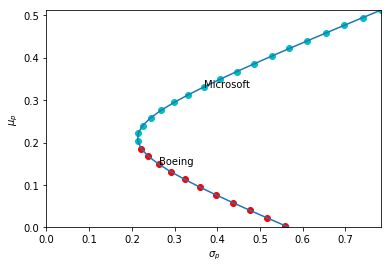

In [5]:
%matplotlib inline
plt.figure();
colors=np.concatenate((np.repeat('c', 18), np.repeat('r', 13)), axis=0)
plt.plot(sigma_portfolio, mu_portfolio)
plt.ylim(0, max(mu_portfolio))
plt.xlim(0, max(sigma_portfolio))
plt.xlabel(r'$\sigma_p$')
plt.ylabel(r'$\mu_p$')

for x, y, c in zip(sigma_portfolio, mu_portfolio, colors):
    plt.scatter(x, y, color=c)
    
plt.text(x=sigma_boeing, y=mu_boeing, s="Boeing")
plt.text(x=sigma_msft, y=mu_msft, s="Microsoft")

# Adding T-bills to your portfolios

Use an annual risk-free rate of 3% per year for the T-billand and create a set of portfolios with the T-bills and the Boeing stock as underlying assets. Again, you are allowed to take short positions in both assets.

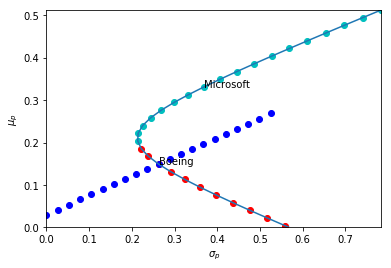

In [6]:
# Annual risk-free rate of 3% per year for the T-bill
t_bill_rate = 0.03

# Ratio Boeing stocks
boeing_weights = np.arange(-1, 2.1, 0.1)

# Portfolio parameters
mu_portfolio_boeing_bill = boeing_weights * mu_boeing + (1-boeing_weights) * t_bill_rate

sigma_portfolio_boeing_bill = boeing_weights * sigma_boeing

# Plot previous exercise
plt.figure();
colors=np.concatenate((np.repeat('c', 18), np.repeat('r', 13)), axis=0)
plt.plot(sigma_portfolio, mu_portfolio)
plt.ylim(0, max(mu_portfolio))
plt.xlim(0, max(sigma_portfolio))
plt.xlabel(r'$\sigma_p$')
plt.ylabel(r'$\mu_p$')

for x, y, c in zip(sigma_portfolio, mu_portfolio, colors):
    plt.scatter(x, y, color=c)
    
plt.text(x=sigma_boeing, y=mu_boeing, s="Boeing")
plt.text(x=sigma_msft, y=mu_msft, s="Microsoft")

# Portfolio Combination Boeing and T-bills
plt.scatter(sigma_portfolio_boeing_bill, mu_portfolio_boeing_bill, marker="o", c="b")

# The Sharpe Slope

In [7]:
# Sharp ratio Boeing
sharp_ratio_boeing = (mu_boeing - t_bill_rate) / sigma_boeing

# Global Minimum Variance Portfolio

The global minimum variance portfolio is the portfolio that provides you with the lowest possible portfolio volatility for a number of underlying assets. 

In [8]:
#source from https://blog.quantopian.com/markowitz-portfolio-optimization-2/

#parameters:
#      expectedReturn as a vector with dimension n X 1
#      covarianceMatrix as a matrix with dimension n X n

def optimal_portfolio(expectReturn, covarianceMatrix):
    # Convert to cvxopt matrices
    n = len(expectReturn)

    pbar = opt.matrix(np.asmatrix(expectReturn))
    S = opt.matrix(np.asmatrix(covarianceMatrix))

    # Create constraint matrices
    P = S
    q = opt.matrix(0.0, (n, 1))
    
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    wt = solvers.qp(P, q, G, h, A, b)['x']
    
    wt = np.asarray(wt)
    returns = wt.transpose() * expectReturn
    risks = np.sqrt(wt.transpose() * np.asmatrix(covarianceMatrix) * wt)

    return {'weight': wt, 'er': np.asscalar(returns), 'sd':np.asscalar(risks) }

     pcost       dcost       gap    pres   dres
 0:  2.5116e-02 -9.8968e-01  1e+00  3e-16  2e+00
 1:  2.4720e-02  1.6732e-03  2e-02  2e-16  5e-02
 2:  2.2914e-02  2.1418e-02  1e-03  6e-17  6e-04
 3:  2.2877e-02  2.2860e-02  2e-05  6e-17  4e-06
 4:  2.2877e-02  2.2877e-02  2e-07  6e-17  4e-08
 5:  2.2877e-02  2.2877e-02  2e-09  2e-16  4e-10
Optimal solution found.


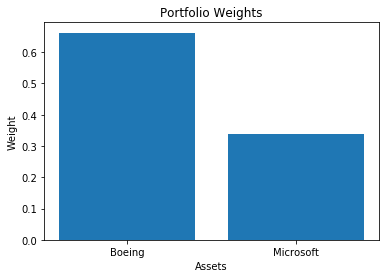

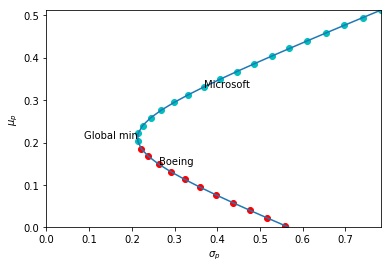

In [9]:
annual_return = np.asmatrix(mu_hat_annual).transpose()

opt_portfolio = optimal_portfolio(annual_return, cov_mat_annual)

#Plot the optimial weight
plt.figure();
plt.bar(range(2), opt_portfolio['weight'])
plt.xticks((0,1), ('Boeing', 'Microsoft'))
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.title('Portfolio Weights')
plt.show()

# Plot previous exercise
plt.close("all")
colors=np.concatenate((np.repeat('c', 18), np.repeat('r', 13)), axis=0)
plt.plot(sigma_portfolio, mu_portfolio)
plt.ylim(0, max(mu_portfolio))
plt.xlim(0, max(sigma_portfolio))
plt.xlabel(r'$\sigma_p$')
plt.ylabel(r'$\mu_p$')

for x, y, c in zip(sigma_portfolio, mu_portfolio, colors):
    plt.scatter(x, y, color=c)
    
plt.text(x=sigma_boeing, y=mu_boeing, s="Boeing")
plt.text(x=sigma_msft, y=mu_msft, s="Microsoft")
plt.text(x=opt_portfolio['sd'], y=opt_portfolio['er'], s="Global min", ha='right')

plt.show()

# Tangency Portfolio

The tangency portfolio is the portfolio on the efficient frontier with the highest Sharpe ratio. 

In [10]:
#tranlsation of tangency.portfolio in https://github.com/algoquant/scripts/blob/master/Zivot%20portfolio.R

#parameters:
#      expectedReturn as a vector with dimension n X 1
#      covarianceMatrix as a matrix with dimension n X n

def tangency_portfolio(expectReturn, covarianceMatrix, riskFreeRate):

    er = opt.matrix(np.asmatrix(expectReturn))
    covMatrix = opt.matrix(np.asmatrix(covarianceMatrix))
    
    if(riskFreeRate < 0):
        raise TypeError("Risk-free rate must be positive")
    
    if(len(er) != covMatrix.size[0]):
        raise TypeError("invalid inputs")
    
    opt_portfolio = optimal_portfolio(expectReturn, covarianceMatrix)
    
    if opt_portfolio['er'] < riskFreeRate:
        raise TypeError("Risk-free rate must be positive")
        
    inv = np.linalg.inv(covMatrix)
    
    weights = np.matmul(inv, (er - riskFreeRate))
    weights = weights / np.sum(weights)
    
    returns = weights.transpose() * expectReturn
    risks = np.sqrt(weights.transpose() * np.asmatrix(covarianceMatrix) * weights)
    
    return {'weight': weights, 'er':np.asscalar(returns), 'sd':np.asscalar(risks) }

     pcost       dcost       gap    pres   dres
 0:  2.5116e-02 -9.8968e-01  1e+00  3e-16  2e+00
 1:  2.4720e-02  1.6732e-03  2e-02  2e-16  5e-02
 2:  2.2914e-02  2.1418e-02  1e-03  6e-17  6e-04
 3:  2.2877e-02  2.2860e-02  2e-05  6e-17  4e-06
 4:  2.2877e-02  2.2877e-02  2e-07  6e-17  4e-08
 5:  2.2877e-02  2.2877e-02  2e-09  2e-16  4e-10
Optimal solution found.


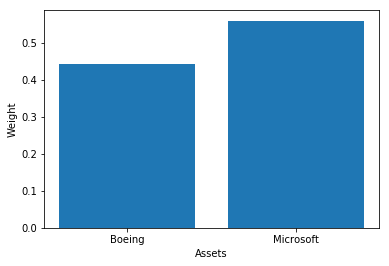

In [11]:
tan_portfolio = tangency_portfolio(annual_return, cov_mat_annual, 0.03)

#Plot the optimial weight
plt.figure();
plt.bar(range(2), tan_portfolio['weight'], label='Portfolio Weights')
plt.xticks((0,1), ('Boeing', 'Microsoft'))
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.show()

# Tangency portfolio and T-bills

Create new portfolios that are a combination of T-bills and this tangency portfolio

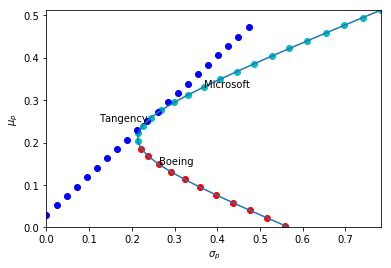

In [12]:
# Annual risk-free rate of 3% per year for the T-bill
t_bill_rate = 0.03

# Set of tangency portfolio weights
tangency_weights = np.arange(-1, 2.1, 0.1)

# Portfolio parameters
mu_portfolio_tangency_bill = t_bill_rate + tangency_weights * (tan_portfolio['er'] - t_bill_rate)

sigma_portfolio_tangency_bill = tan_portfolio['sd']*tangency_weights

# Plot previous exercise
plt.close("all")
colors=np.concatenate((np.repeat('c', 18), np.repeat('r', 13)), axis=0)
plt.plot(sigma_portfolio, mu_portfolio)
plt.ylim(0, max(mu_portfolio))
plt.xlim(0, max(sigma_portfolio))
plt.xlabel(r'$\sigma_p$')
plt.ylabel(r'$\mu_p$')

for x, y, c in zip(sigma_portfolio, mu_portfolio, colors):
    plt.scatter(x, y, color=c)
    
plt.text(x=sigma_boeing, y=mu_boeing, s="Boeing")
plt.text(x=sigma_msft, y=mu_msft, s="Microsoft")
plt.text(x=tan_portfolio['sd'], y=tan_portfolio['er'], s="Tangency", ha='right')

# Portfolio Combination Boeing and T-bills
plt.scatter(sigma_portfolio_tangency_bill, mu_portfolio_tangency_bill, marker="o", c="b")

# An Efficient Portfolio with 30% Tangency

Consider a portfolio that has 30% invested in the tangency portfolio and 70% in T-bills. Before making the final call, you want to investigate this portfolio's return and volatility in more detail.

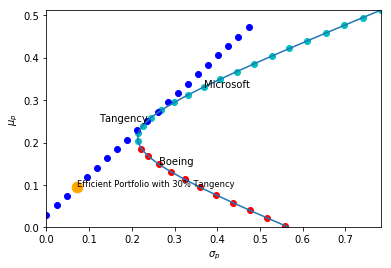

In [13]:
# Define the portfolio ratio's
tangency_weight = 0.3
t_bill_weight = 1 - tangency_weight

# Define the portfolio parameters
mu_portfolio_efficient = t_bill_rate +  tangency_weight * (tan_portfolio['er']-t_bill_rate)

sd_portfolio_efficient = tangency_weight * tan_portfolio['sd']

# Plot previous exercise
plt.close("all")
colors=np.concatenate((np.repeat('c', 18), np.repeat('r', 13)), axis=0)
plt.plot(sigma_portfolio, mu_portfolio)
plt.ylim(0, max(mu_portfolio))
plt.xlim(0, max(sigma_portfolio))
plt.xlabel(r'$\sigma_p$')
plt.ylabel(r'$\mu_p$')

for x, y, c in zip(sigma_portfolio, mu_portfolio, colors):
    plt.scatter(x, y, color=c)
    
plt.text(x=sigma_boeing, y=mu_boeing, s="Boeing")
plt.text(x=sigma_msft, y=mu_msft, s="Microsoft")
plt.text(x=tan_portfolio['sd'], y=tan_portfolio['er'], s="Tangency", ha='right')

# Portfolio Combination Boeing and T-bills
plt.scatter(sigma_portfolio_tangency_bill, mu_portfolio_tangency_bill, marker="o", c="b")

# Plot Efficient Portfolio with 30% Tangency
plt.text(x=sd_portfolio_efficient, y=mu_portfolio_efficient, s="Efficient Portfolio with 30% Tangency", size='small')
plt.scatter(sd_portfolio_efficient, mu_portfolio_efficient, s=np.pi*(6)**2, marker="o", c="orange")

# An Efficient Portfolio with the SD of Boeing

find the efficient portfolio (combination of T-bills and tangency portfolio) that has the same risk (SD) as Boeing.

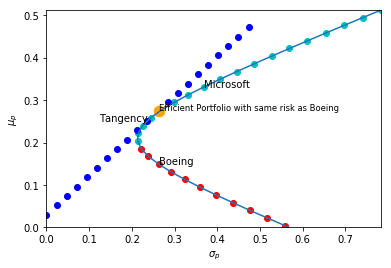

In [14]:
# Calculate the weight of the tangency portfolio in the portfolio
tangency_weight  = sigma_boeing/tan_portfolio['sd']

# Calculate the portfolio parameters
mu_portfolio_efficient = t_bill_rate + tangency_weight * (tan_portfolio['er'] - t_bill_rate)

sd_portfolio_efficient = tangency_weight * tan_portfolio['sd']

# Plot previous exercise
plt.close("all")
colors=np.concatenate((np.repeat('c', 18), np.repeat('r', 13)), axis=0)
plt.plot(sigma_portfolio, mu_portfolio)
plt.ylim(0, max(mu_portfolio))
plt.xlim(0, max(sigma_portfolio))
plt.xlabel(r'$\sigma_p$')
plt.ylabel(r'$\mu_p$')

for x, y, c in zip(sigma_portfolio, mu_portfolio, colors):
    plt.scatter(x, y, color=c)
    
plt.text(x=sigma_boeing, y=mu_boeing, s="Boeing")
plt.text(x=sigma_msft, y=mu_msft, s="Microsoft")
plt.text(x=tan_portfolio['sd'], y=tan_portfolio['er'], s="Tangency", ha='right')

# Portfolio Combination Boeing and T-bills
plt.scatter(sigma_portfolio_tangency_bill, mu_portfolio_tangency_bill, marker="o", c="b")

# Plot Efficient Portfolio with the same risk as Boeing
plt.text(x=sd_portfolio_efficient, y=mu_portfolio_efficient, s="Efficient Portfolio with same risk as Boeing", size='small')
plt.scatter(sd_portfolio_efficient, mu_portfolio_efficient, s=np.pi*(6)**2, marker="o", c="orange")
